In [4]:
import os
import re
import sys
import glob
import random
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

## Zeros for cosine similarity

In [13]:
a = [5,1,40,2,10]
b = [0,2,34,4,18]

print("CosSim:", 1-spatial.distance.cosine(a,b))

CosSim: 0.9621948256285112


In [16]:
a = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,40,2,10]
b = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,34,4,18]

print("CosSim:", 1-spatial.distance.cosine(a,b))

CosSim: 0.9621948256285113


## Prepare Data

### Mammals outgrp mito

In [2]:
ref = next(SeqIO.parse("../data/mammals/raw/outgrp.gb", format="gb"))
ref.description

'Cociella crocodila voucher HABs-2016-007 mitochondrion, complete genome'

In [46]:
for f in ref.features:
    if f.type == "CDS":
        if f.qualifiers["gene"] == ['CYTB']:
            cytb = str(f.extract(ref.seq))
        if f.qualifiers["gene"] == ['ND1']:
            nd1 = str(f.extract(ref.seq))

In [47]:
print(cytb)
print(nd1)

ATGGCCAACTTACGAAAAACCCACCCCTTACTCAAAATTGCTAACAATGCTTTAGTAGACCTCCCCGCCCCCTCCAACATCTCCGCATGATGAAACTTTGGGTCCCTTTTAGGACTATGCTTAATTATCCAAATCCTCTCAGGCTTATTTCTAGCTATACATTACACATCAGATGTCGCTACAGCCTTCTCCTCCGTTGCCCACATCTGCCGAGACGTAAATTACGGCTGGCTAATTCGCAATCTCCACGCAAACGGAGCATCATTCTTTTTTATCTGCATTTATATACACATCGGACGCGGCCTCTACTACGGATCATACCTTTTTAAAGAGACATGAAACATTGGCGTCGTGCTCTTGCTCCTCGTAATAGTCACCGCTTTCGTGGGCTACGTCCTCCCCTGAGGACAAATATCATTCTGAGGCGCCACGGTTATTACCAACCTTCTGTCCGCCGTCCCTTATATTGGTAACACCCTCGTTCAATGAATCTGAGGAGGCTTCTCAGTAGATAATGCTACATTAAACCGTTTCTTCGCGTTCCATTTCCTTTTCCCGTTCATCATCGCAGCCGCCACTATAATCCACCTTCTATTCCTTCACCAAACTGGTTCTAACAACCCGCTTGGGCTATGGCTCAACACAGACAAAATTTCCTTCCACCCCTACTTCTCATATAAAGACCTCTTAGGGTTCGCAGGCCTTCTACTGACCTTAACAGCTTTAGCACTTTTTTCTCCCAACCTCTTAGGAGATCCTGATAACTTCACCCCGGCCAACCCCCTCGTAACCCCTCCCCATATTAAACCAGAATGATACTTCTTATTTGCATACGCTATTCTCCGCTCAATCCCTAATAAACTAGGAGGCGTACTAGCCCTCCTAGCCTCAATCTTAATTCTCATACTAATCCCGATTCTTCACACATCAAAACAACGAAGTTTAACATTCCGCCCTGTCTCTCAACTCCTGTTCTGGGCCCTTATTGCAGACGTCGCAA

### Human mito

In [48]:
ref = pymutspec.io.read_genbank_ref("../data/NC_012920.1.gb")

In [49]:
def get_gene(gname: str):
    """
    ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3',
       'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']
    """
    seq = "".join(ref[ref.GeneName == gname].Nuc.values)
    return seq 

In [50]:
ct = CodonTable.unambiguous_dna_by_id[2]

for g in ['ND1', 'CYTB']:
    s = Seq.Seq(get_gene(g))
    print(g)
    print(str(s.translate(2)))
    print()

ND1
MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT

CYTB
MTPMRKTNPLMKLINHSFIDLPTPSNISAWWNFGSLLGACLILQITTGLFLAMHYSPDASTAFSSIAHITRDVNYGWIIRYLHANGASMFFICLFLHIGRGLYYGSFLYSETWNIGIILLLATMATAFMGYVLPWGQMSFWGATVITNLLSAIPYIGTDLVQWIWGGYSVDSPTLTRFFTFHFILPFIIAALATLHLLFLHETGSNNPLGITSHSDKITFHPYYTIKDALGLLLFLLSLMTLTLFSPDLLGDPDNYTLANPLNTPPHIKPEWYFLFAYTILRSVPNKLGGVLALLLSILILAMIPILHMSKQQSMMFRPLSQSLYWLLAADLLILTWIGGQPVSYPFTIIGQVASVLYFTTILILMPTISLIENKMLKWA



### Extract genes from alignment of genomes

In [51]:
genomes = []
genes = {}
for rec in SeqIO.parse("../data/GAGP/Mitochondria_GreatApes.muscle2.fasta2line", format="fasta"):
    if rec.id in ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']:
        genes[rec.id] = str(rec.seq)
    else:
        genomes.append(rec)

In [52]:
genes_pos = {}
for g, seq in genes.items():
    m = re.match("(-+)(\w+)(-+)", seq)
    n = len(seq)
    if sum([len(x) for x in m.groups()]) == n:
        gaps_up, _, gaps_down = m.groups()
        p1 = len(gaps_up)
        p2 = n - len(gaps_down)
        genes_pos[g] = tuple((p1, p2))
    else:
        print("errror")
        break

In [53]:
genes_pos

{'ND6': (13620, 14145),
 'COX3': (8677, 9461),
 'ND3': (9529, 9875),
 'ND4L': (9940, 10230),
 'ATP6': (7997, 8677),
 'ND5': (11808, 13620),
 'ATP8': (7836, 7997),
 'COX2': (7038, 7722),
 'COX1': (5355, 6897),
 'ND1': (2741, 3697),
 'ND2': (3904, 4946),
 'ND4': (10230, 11608),
 'CYTB': (14218, 15359)}

In [54]:
new_records = []
for gene, (p1, p2) in genes_pos.items():
    grec = []
    for genome in genomes:
        seq = genome.seq[p1: p2]
        idx = genome.id + "_" + gene
        r = SeqRecord.SeqRecord(seq, idx, idx, idx)
        new_records.append(r)
        grec.append(r)

    with open(f"../data/GAGP/genes/{gene}.fna", "w") as handle:
        SeqIO.write(grec, handle, "fasta-2line")

# with open("../data/GAGP/genes.fna", "w") as handle:
#     SeqIO.write(new_records, handle, "fasta-2line")

## Site rates categories

### HUMAN

In [5]:
path_to_hrates = "../data/HOMINIDAE/human_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
hrates = pd.concat(data)

In [6]:
hrates_cats = hrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
hrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
COX1,1031,0,64,156,54,118,128
CYTB,671,12,45,158,20,117,120
ND1,560,9,44,130,27,93,91


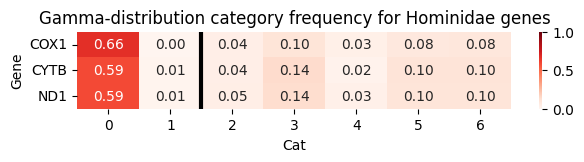

In [8]:
plt.figure(figsize=(7, 1))
plt.title("Gamma-distribution category frequency for Hominidae genes")
sns.heatmap((hrates_cats.T / hrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_human.pdf", bbox_inches="tight")
plt.show()

### MUS

In [9]:
path_to_hrates = "../data/MUS/mus_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
mrates = pd.concat(data)

In [10]:
mrates_cats = mrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
COX1,1064,47,44,126,53,101,110
CYTB,565,74,67,79,120,133,63
ND1,581,36,65,76,51,75,73


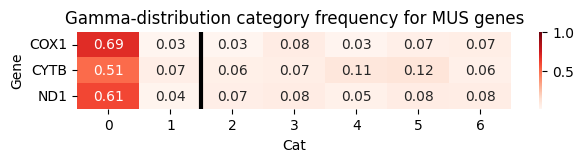

In [11]:
plt.figure(figsize=(7, 1))
plt.title("Gamma-distribution category frequency for MUS genes")
sns.heatmap((mrates_cats.T / mrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mus.pdf", dpi=300,bbox_inches="tight")
plt.show()

### Mammals

In [27]:
data = []
d = pd.read_csv("../data/exposure/mammals_nd1/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "ND1"
data.append(d)
d = pd.read_csv("../data/exposure/mammals_cytb/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "CYTB"
data.append(d)
mam_rates = pd.concat(data)

In [28]:
mam_rates_cats = mam_rates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mam_rates_cats

Cat,0,1,2,3,4,5
Gene,,,,,,
CYTB,499,106,81,121,207,126
ND1,402,85,84,110,150,123


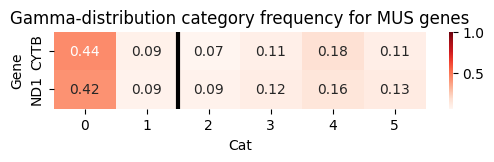

In [29]:
plt.figure(figsize=(6, 1))
plt.title("Gamma-distribution category frequency for Mammals genes")
sns.heatmap((mam_rates_cats.T / mam_rates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mammals.pdf", bbox_inches="tight")
plt.show()

## Expected mutations excluding invariant positions

In [25]:
coda = CodonAnnotation(2)

In [84]:
human_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_cytb/alignment_checked.fasta", format="fasta")]
human_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_nd1/alignment_checked.fasta", format="fasta")]
human_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_cytb/CYTB.rate"))[1]
human_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_nd1/ND1.rate"))[1]
human_cytb_rate = pd.read_csv("../data/exposure/human_cytb/CYTB.rate", comment="#", sep="\t")
human_nd1_rate  = pd.read_csv("../data/exposure/human_nd1/ND1.rate", comment="#", sep="\t")

mus_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_cytb/alignment_checked.fasta", format="fasta")]
mus_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_nd1/alignment_checked.fasta", format="fasta")]
mus_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_cytb/CYTB.rate"))[1]
mus_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_nd1/ND1.rate"))[1]
mus_cytb_rate = pd.read_csv("../data/exposure/mus_cytb/CYTB.rate", comment="#", sep="\t")
mus_nd1_rate  = pd.read_csv("../data/exposure/mus_nd1/ND1.rate", comment="#", sep="\t")

for _df in [human_cytb_rate, human_nd1_rate, mus_cytb_rate, mus_nd1_rate]:
    _df["Pos"] = np.arange(len(_df)) + 1

mammals_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_cytb/alignment_checked.fasta", format="fasta")]
mammals_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_nd1/alignment_checked.fasta", format="fasta")]
mammals_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_cytb/iqtree.rate"))[1]
mammals_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_nd1/iqtree.rate"))[1]

In [51]:
lbl = "syn"
full_exp_summary = []

### Human CYTB

In [52]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
n = 500
for seq in random.sample(human_cytb, n):
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / n
        exp_masked12[sbs] += em12[lbl][sbs] / n

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / n
        exp_masked192[sbs] += em192[lbl][sbs] / n


In [54]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[0][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,88.264,138.320,88.264,88.082,88.082,207.972,13.270,6.782,6.782,15.128,54.722,15.128
exp_masked,61.076,88.428,61.076,61.124,61.124,146.118,12.236,6.764,6.764,15.092,54.656,15.092


In [55]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

### Human ND1

In [57]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
n = 500
for seq in random.sample(human_nd1, n):
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / n
        exp_masked12[sbs] += em12[lbl][sbs] / n

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / n
        exp_masked192[sbs] += em192[lbl][sbs] / n


In [58]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[1][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,69.910,116.682,69.910,91.436,91.436,178.300,17.124,9.036,9.036,16.210,42.080,16.210
exp_masked,48.942,77.782,48.942,73.486,73.486,134.374,16.094,9.026,9.026,15.184,39.048,15.184


In [59]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

### Mus CYTB

In [61]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_cytb)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [62]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[2][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,99.881818,153.127273,99.881818,44.336364,44.336364,145.437662,10.094805,5.801299,5.801299,18.941558,79.871429,18.941558
exp_masked,94.044156,141.323377,94.044156,44.336364,44.336364,144.519481,10.087013,5.796104,5.796104,18.929870,78.864935,18.929870


### Mus ND1

In [63]:
# import re

# from Bio import SeqIO
# import pandas as pd

# rates = pd.read_csv("data/MUS/mus_rates/ND1.rate", sep='\t', comment="#")

# non_letters_positions = set()  # 1-BASED
# for rec in SeqIO.parse("data/exposure/mus_nd1/raw_aln.fna", format="fasta"):
#     seq = str(rec.seq)
#     for i in range(0, len(seq), 3):
#         codon = seq[i: i+3]
#         if not re.match("[A-Za-z]{3}", codon):
#             non_letters_positions.add(i+1)
#             non_letters_positions.add(i+2)
#             non_letters_positions.add(i+3)

# print(sorted(non_letters_positions))

# df = rates[~rates.Site.isin(non_letters_positions)]
# df.to_csv("data/exposure/mus_nd1/ND1.rate", index=False, sep="\t")

In [64]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_nd1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [65]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[3][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,93.265957,162.074468,93.265957,39.946809,39.946809,113.776596,10.978723,7.765957,7.765957,21.074468,79.829787,21.074468
exp_masked,67.361702,109.085106,67.361702,39.946809,39.946809,101.510638,9.989362,6.776596,6.776596,21.063830,75.031915,21.063830


### Mammals CYTB

In [41]:
# exp12, exp192 = defaultdict(int), defaultdict(int)
# exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
# for seq in mammals_cytb:
#     e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
#     em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_cytb_mask, [lbl])

#     for sbs in e12[lbl]:
#         exp12[sbs] += e12[lbl][sbs] / len(mammals_cytb)
#         exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_cytb)

#     for sbs in e192[lbl]:
#         exp192[sbs] += e192[lbl][sbs] / len(mammals_cytb)
#         exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_cytb)

# dct = dict()
# for sbs in possible_sbs12:
#     dct[sbs] = exp_masked12[sbs]
# for sbs in possible_sbs192:
#     dct[sbs] = exp_masked192.get(sbs, 0.)

# exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
# exp_muts["Label"] = "syn"

# # exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [42]:
# full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
# full_exp_summary[4][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,100.181543,153.391831,100.181543,55.793495,55.793495,167.981089,13.710287,7.647504,7.647504,28.459909,83.393343,28.459909
exp_masked,100.181543,153.391831,100.181543,55.793495,55.793495,167.660363,12.711800,7.647504,7.647504,28.459909,83.272315,28.459909


### Mammals ND1

In [43]:
# exp12, exp192 = defaultdict(int), defaultdict(int)
# exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
# for seq in mammals_nd1:
#     e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
#     em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_nd1_mask, [lbl])

#     for sbs in e12[lbl]:
#         exp12[sbs] += e12[lbl][sbs] / len(mammals_nd1)
#         exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_nd1)

#     for sbs in e192[lbl]:
#         exp192[sbs] += e192[lbl][sbs] / len(mammals_nd1)
#         exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_nd1)

# dct = dict()
# for sbs in possible_sbs12:
#     dct[sbs] = exp_masked12[sbs]
# for sbs in possible_sbs192:
#     dct[sbs] = exp_masked192.get(sbs, 0.)

# exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
# exp_muts["Label"] = "syn"

# # exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [44]:
# full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
# full_exp_summary[5][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,89.97432,147.533988,89.97432,49.350453,49.350453,127.271903,12.555891,6.604985,6.604985,25.165408,71.724320,25.165408
exp_masked,89.97281,146.519637,89.97281,49.350453,49.350453,127.057402,11.577795,6.466767,6.466767,25.165408,71.642749,25.165408


### Merge Human, Mouse and Mammals

In [68]:
# a = pd.concat(full_exp_summary)
# a["Species"] = np.repeat(["Human", "Mouse", "Mammals"], 4)
# a["Gene"] = np.repeat(np.tile(["CYTB", "ND1"], 3), 2)

a = pd.concat(full_exp_summary)
a["Species"] = np.repeat(["Human", "Mouse"], 4)
a["Gene"] = np.repeat(np.tile(["CYTB", "ND1"], 2), 2)

a.reset_index().rename(columns={"index": "Label"}).set_index(["Species", "Gene", "Label"]).round(2)

G>A     C>T    C>A    C>G     A>G    A>C    A>T  \
Species Gene Label                                                           
Human   CYTB exp         13.27  207.97  88.08  88.08  138.32  88.26  88.26   
             exp_masked  12.24  146.12  61.12  61.12   88.43  61.08  61.08   
        ND1  exp         17.12  178.30  91.44  91.44  116.68  69.91  69.91   
             exp_masked  16.09  134.37  73.49  73.49   77.78  48.94  48.94   
Mouse   CYTB exp         10.09  145.44  44.34  44.34  153.13  99.88  99.88   
             exp_masked  10.09  144.52  44.34  44.34  141.32  94.04  94.04   
        ND1  exp         10.98  113.78  39.95  39.95  162.07  93.27  93.27   
             exp_masked   9.99  101.51  39.95  39.95  109.09  67.36  67.36   

                           T>C    T>G    T>A   G>C   G>T  
Species Gene Label                                        
Human   CYTB exp         54.72  15.13  15.13  6.78  6.78  
             exp_masked  54.66  15.09  15.09  6.76  6.76  
        ND1  exp         42.08  16.21  16.21  9.04  9.04  
             exp_masked  39.05  15.18  15.18  9.03  9.03  
Mouse   CYTB exp         79.87  18.94  18.94  5.80  5.80  
             exp_masked  78.86  18.93  18.93  5.80  5.80  
        ND1  exp         79.83  21.07  21.07  7.77  7.77  
             exp_masked  75.03  21.06  21.06  6.78  6.78

## Intersection of invariant and synonymous positions

In [96]:
# for each gene in alignment get expected mutations,
# assign invariativity to each position
# and calculate how many positions are invariant

n = 500
em_total = []
for lbl, aln, mask, rates in zip(
    ['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1', ], 
    [human_cytb, human_nd1, mus_cytb, mus_nd1, ], 
    [human_cytb_mask, human_nd1_mask, mus_cytb_mask, mus_nd1_mask, ],
    [human_cytb_rate, human_nd1_rate, mus_cytb_rate, mus_nd1_rate, ]
    ):
    em = []
    aln = random.sample(aln, n) if len(aln) > n else aln
    for seq in aln:
        em.append(coda.collect_exp_muts(seq))
    em = pd.concat(em).merge(rates, on="Pos")
    em["Gene"] = lbl
    em_total.append(em)

em_total_df = pd.concat(em_total)
em_total_df["Invariant"] = (em_total_df.Cat < 2).astype(np.int8)

In [101]:
em_total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197801 entries, 0 to 64931
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Pos        1197801 non-null  int64  
 1   Pic        1197801 non-null  int64  
 2   Mut        1197801 non-null  object 
 3   MutBase    1197801 non-null  object 
 4   Cdn        1197801 non-null  object 
 5   Label      1197801 non-null  object 
 6   Site       1197801 non-null  int64  
 7   Rate       1197801 non-null  float64
 8   Cat        1197801 non-null  int64  
 9   C_Rate     1197801 non-null  float64
 10  Gene       1197801 non-null  object 
 11  Invariant  1197801 non-null  int8   
dtypes: float64(2), int64(4), int8(1), object(5)
memory usage: 110.8+ MB


In [102]:
em_total_df.head()

,Pos,Pic,Mut,MutBase,Cdn,Label,Site,Rate,Cat,C_Rate,Gene,Invariant
0,3,3,T[G>A]A,G>A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
1,3,3,T[G>A]A,G>A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
2,3,3,T[G>A]A,G>A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
3,3,3,T[G>A]A,G>A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
4,3,3,T[G>A]A,G>A,ATG,syn,3,0.05365,0,0.0,human_cytb,1


In [100]:
(em_total_df.groupby("Gene").Cat.value_counts(normalize=True).unstack() * 100).round(2)
# Category frequency for SYN mutations

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
human_cytb,27.29,NaN,1.85,25.87,2.47,19.02,23.50
human_nd1,22.79,0.14,3.43,24.64,5.50,20.19,23.32
mus_cytb,3.22,0.28,7.54,14.27,23.49,30.42,20.77
mus_nd1,15.75,2.32,11.43,17.86,9.20,18.23,25.21
